<a href="https://colab.research.google.com/github/0xpix/BirdDetection/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instructions
Before you start:
- Go to the shared [Google Drive](https://drive.google.com/file/d/1kog4Y9Ts9hl_jq-DVg_WboWNWpgHEF7c/view?usp=drive_link)
- Select Data.zip "Add shortcut to Drive" and select "My Drive".
- Go Back to Colab
- Click > File > Save a copy in Drive


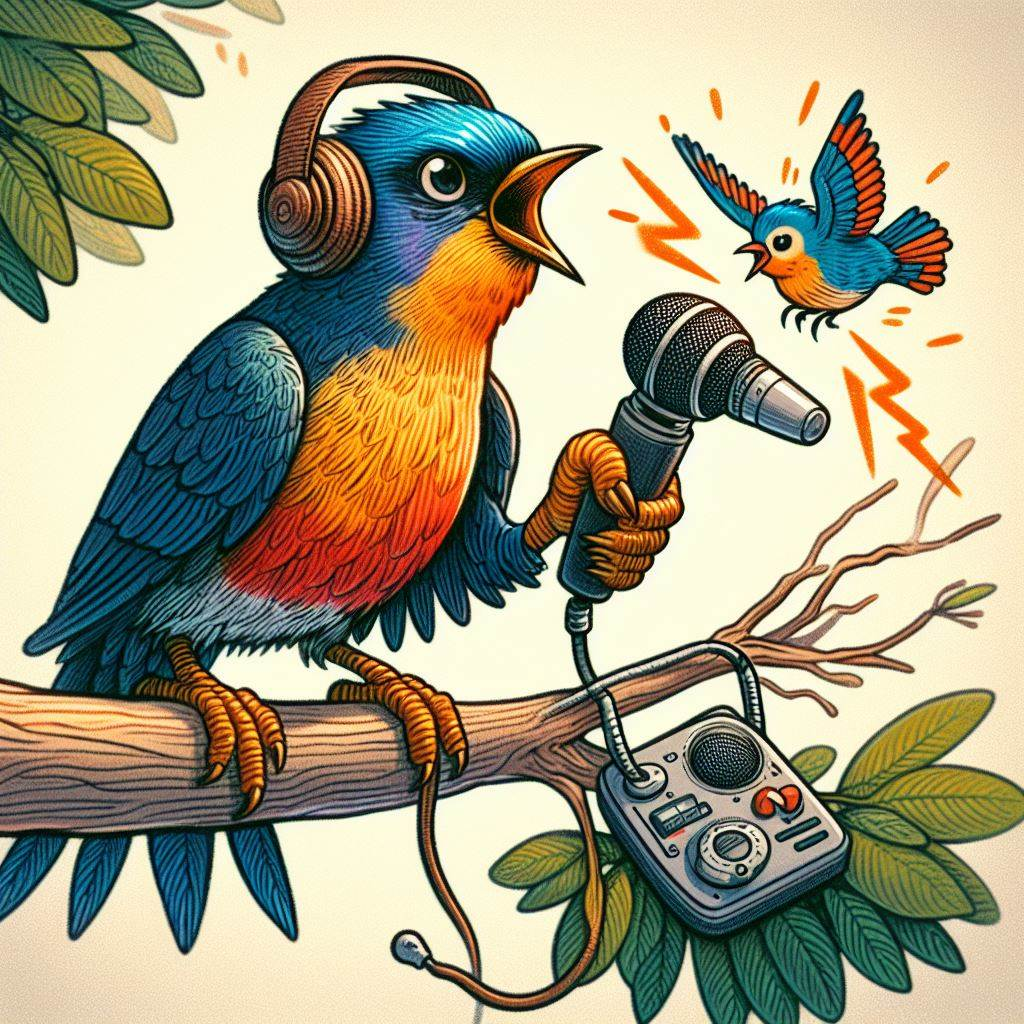

Generated by DALLE-3

# Developing an Automatic Recording Unit (ARU) with a Raspberry Pi 🐦

Collected sounds from 🚌[Intaka Island in Cape Town](https://intaka.co.za), manually annotated the 📂[data](https://drive.google.com/drive/folders/1cG94j1OHZPMCgZ6wUc-2mbCuXkd8INQ7?usp=sharing), and are now training a 🤖model to classify future 🎯spectrograms based on sound presence. 🎤🌿🔊

# Importing Libraries

In [ ]:
%%capture
!pip install librosa == 0.10.1
!pip install resampy

In [ ]:
# Loading the Data
from google.colab import drive
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile

# Google Authentication
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download files
downloaded = drive.CreateFile({'id':"1kog4Y9Ts9hl_jq-DVg_WboWNWpgHEF7c"}) # Replace with the ID of the shortcut Data.
downloaded.GetContentFile('Data.rar')

# Extract files to temporary location in Google Drive
with zipfile.ZipFile('Data.rar', 'r') as zip_file:
    zip_file.extractall()

In [ ]:
# Audio Libraries
# ----------------
import librosa
import librosa.display
from IPython.display import Audio
from IPython.display import Image

# Other Libraries
# ----------------
# !pip install SoundFile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections
import math
import os
import time
import random
import scipy
from scipy import signal
from tqdm import tqdm
from itertools import count

# Helper functions

In [ ]:
# audio to spectogram
def audio_to_spectrogram(audio, hop_length=None, fmin=None, fmax=None, n_mels=None):
    peak_amplitude = np.max(np.abs(audio))
    target_peak_level = -1
    gain = target_peak_level / peak_amplitude
    normalized_audio = audio * gain
    normalized_audio = np.clip(normalized_audio, -1, 1)

    # Compute STFT
    stft = librosa.stft(
        normalized_audio,
        n_fft=n_fft,
        hop_length=hop_length

    )
    amplitude_spectrogram = np.abs(stft)
    spectrogram_db = librosa.amplitude_to_db(amplitude_spectrogram, ref=np.max)

    return spectrogram_db

# segments ogram to image
def convert_all_to_image(segments):
    spectrograms = []
    for segment in segments:
        spectrograms.append(audio_to_spectrogram(segment))

    return np.array(spectrograms)

def plot_loss_curve(history):
    """
    Returns separate loss curves for training and validation metrics.

    Args:
      history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
    """
    loss = history.history['loss']
    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

# Become one with the Data 🐦🎵🌏

## ploting the coordinates

In [ ]:
# Importing the coordonates
coords = pd.read_csv('Coords.csv')
locations = coords[["Recorder","Lat", "Long", "Duration_in_min", "Bird_heard_(Y/N)"]] # extracting the necessary columns
locations.head(10)

,Recorder,Lat,Long,Duration_in_min,Bird_heard_(Y/N)
0,Aurel,-33.889577,18.514238,14.0,Y
1,Aurel,-33.889697,18.514520,11.0,Y
2,Aurel,-33.889292,18.513862,7.0,Y
3,Aurel,-33.889573,18.513773,15.0,Y
4,Aurel,-33.888790,18.513179,7.0,Y
5,Aurel,-33.889100,18.512987,8.0,Y
6,Aurel,-33.889377,18.513126,10.0,Y
7,Aurel,-33.889639,18.514975,4.0,N
8,Aurel,-33.889814,18.515240,3.0,N
9,Aness,-33.888609,18.513034,28.0,Y


In [ ]:
import folium
from folium import plugins
from branca.element import Figure

fig = Figure(width=1200, height=600)

# https://python-visualization.github.io/folium/latest/user_guide/map.html
# Create a map centered at the chosen location
m = folium.Map(location=[-33.888258, 18.515699], zoom_start=17)

# Add circles and names
for _, location in locations.iterrows():
    duration_hours = location["Duration_in_min"] / 60
    radius = duration_hours * 50

    # if we heard birds the circle will be Green, if not it'll be Red
    if location["Bird_heard_(Y/N)"] == "Y":
        circle_color = "green"
    else:
        circle_color = "red"

    # Code from gis.stackexchange: https://gis.stackexchange.com/questions/381356/how-to-change-circle-opacity-in-folium
    folium.CircleMarker(
        location=[location["Lat"], location["Long"]],
        radius=radius,
        color=circle_color,
        fill=True,
        fill_color=circle_color,
        fill_opacity=0.6,
        popup=f"{location['Recorder']}, {location['Duration_in_min']} m",
    ).add_to(m)

plugins.MousePosition().add_to(m) # adds a small field to your map that shows the coordinates of your mouse position (https://python-visualization.github.io/folium/latest/user_guide/plugins/mouse_position.html)

# Add legend
legend_html = '''
     <div style="position: fixed;
                 bottom: 50px; left: 50px; width: 120px; height: 60px;
                 border:2px solid grey; z-index:9999; font-size:14px;
                 background-color:white;
                 opacity: 0.8;
                 ">
         <p style="margin: 5px; color:green;">Bird Heard</p>
         <p style="margin: 5px; color:red;">Bird Not Heard</p>
     </div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

# Display the map
fig.add_child(m)
m

### Data Preprocessing

In [ ]:
# Do not delete these imports [ 0 marks]
from Preprocessing import *

In [ ]:
positive_class = '1'
negative_class = '0'

# Data hyper-parameters
# -----------------------------
lowpass_cutoff = 10000 # Cutt off for low pass filter
downsample_rate = 24000 # Frequency to downsample to
nyquist_rate = 12000 # Nyquist rate (half of sampling rate)
segment_duration = 2 # how long should a segment be

# Spectrogram hyper-parameters
# -----------------------------
n_fft = 1024 # Hann window length
hop_length = 256 # hop size
n_mels = 128 # number of mells
f_min = 2000 # minimum frequency
f_max = 9000 # maximum frequency

# -----------------------------
species_folder = '.' # Contains /Audio and /Annotations
file_type = 'svl'
audio_extension = '.wav'

In [ ]:
# This takes about 3-4 minutes [ 0 marks]
pre_pro = Preprocessing(species_folder, lowpass_cutoff,
                downsample_rate, nyquist_rate,
                segment_duration,
                positive_class, negative_class,n_fft,
                hop_length, n_mels, f_min, f_max, file_type,
                audio_extension)

X, Y = pre_pro.create_dataset(False)

Processing: 19_19_fermat_15
Found file
Filtering...
Downsampling...
19_19_fermat_15
Reading annotations...
Processing: 23_2-2-2024=20_53_19
Found file
Filtering...
Downsampling...
23_2-2-2024=20_53_19
Reading annotations...
Processing: 6_2-2-2024=14_46_17
Found file
Filtering...
Downsampling...
6_2-2-2024=14_46_17
Reading annotations...
Processing: 9_2-2-2024=21_1_26
Found file
Filtering...
Downsampling...
9_2-2-2024=21_1_26
Reading annotations...
Processing: 6_2-2-2024=14_43_57
Found file
Filtering...
Downsampling...
6_2-2-2024=14_43_57
Reading annotations...
Processing: 23_2-2-2024=20_39_55
Found file
Filtering...
Downsampling...
23_2-2-2024=20_39_55
Reading annotations...
Processing: 15_audio_34
Found file
Filtering...
Downsampling...
15_audio_34
Reading annotations...
Processing: 15_audio_79
Found file
Filtering...
Downsampling...
15_audio_79
Reading annotations...
Processing: 8_emmanuel_5
Found file
Filtering...
Downsampling...
8_emmanuel_5
Reading annotations...
Processing: 23_2-

In [ ]:
# Save the X, Y into a pickle file to save time while optimizing the model (memory issue)
'''
from google.colab import drive
import pickle

drive.mount('/content/drive')

with open("./Pickled_Data/X_and_Y.pkl", "wb") as f:
    pickle.dump([X, Y], f)
'''

## Plot Spectrograms

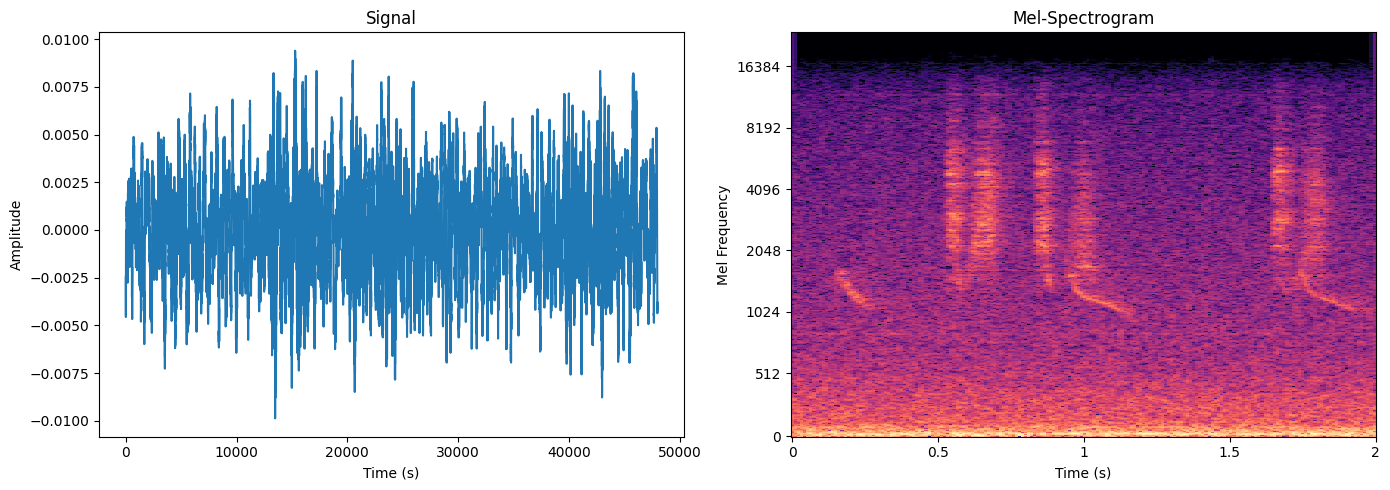

In [ ]:
# audio to spectrogram
segment = X[50]
mel_spec_db = audio_to_spectrogram(segment, hop_length=hop_length, fmin=f_min, fmax=f_max,n_mels = n_mels)

# Plot audio with the respective spectogram
plt.subplots(1, 2, figsize=(14, 5))

# plot audio
plt.subplot(1, 2, 1)
plt.plot(segment)
plt.title('Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# plot the spectogram
plt.subplot(1, 2, 2)
librosa.display.specshow(mel_spec_db, sr=48000, x_axis='time', y_axis='mel')
plt.title('Mel-Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Mel Frequency')

plt.tight_layout()
plt.show()

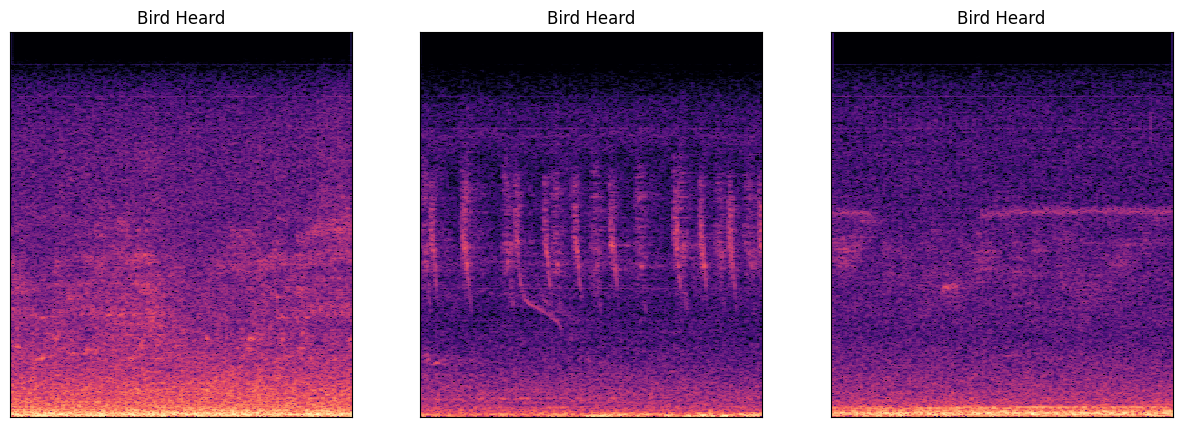

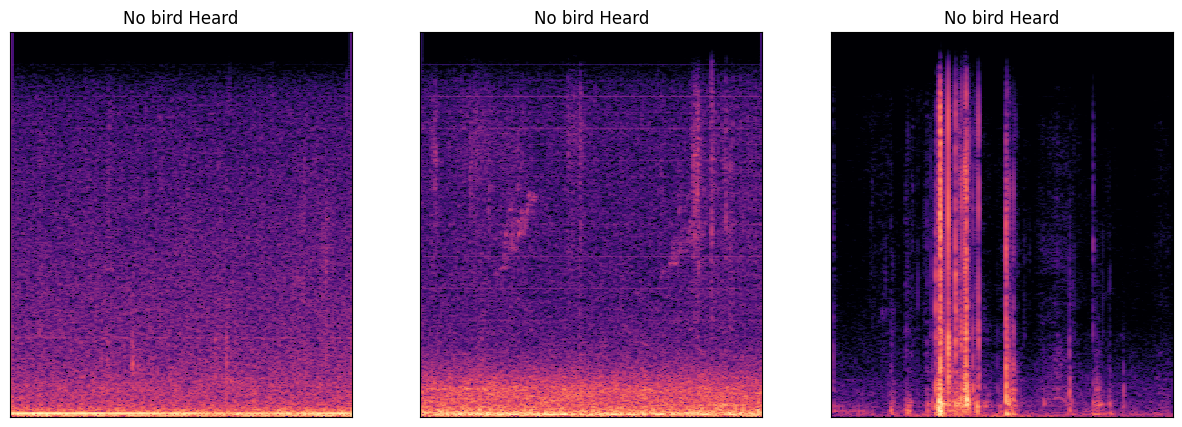

In [ ]:
# Presence and absence indices
presence_indices = [i for i, y in enumerate(Y) if y == '1']
absence_indices = [i for i, y in enumerate(Y) if y == '0']

# Selecting the inices randomly
selected_presence = np.random.choice(presence_indices, min(3, len(presence_indices)), replace=False)
selected_absence = np.random.choice(absence_indices, min(3, len(absence_indices)), replace=False)

# visualising 3 Birds presence events
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in zip(selected_presence, axs):
    librosa.display.specshow(audio_to_spectrogram(X[i]), ax=ax)
    ax.set_title('Bird Heard')
plt.show()

# visualising 3 Birds absence events
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in zip(selected_absence, axs):
    librosa.display.specshow(audio_to_spectrogram(X[i]), ax=ax)
    ax.set_title('No bird Heard')
plt.show()

In [ ]:
# Randomly Select X and Y
def choose_spectrograms(X, Y):
  selected_X = []
  selected_Y = []

  # Create a list of indices for each label
  indices_0 = [i for i, y in enumerate(Y) if y == '0']
  indices_1 = [i for i, y in enumerate(Y) if y == '1']

  random_indices_0 = random.sample(indices_0, 1300)
  random_indices_1 = random.sample(indices_1, 1500)

  for i in random_indices_0:
    selected_X.append(X[i])
    selected_Y.append(Y[i])
  for i in random_indices_1:
    selected_X.append(X[i])
    selected_Y.append(Y[i])

  # Shuffle the lists
  # we combine the X and Y first before shuffling to not lose the mapping (e.g. Y[10] is the label of X[10])
  # if we don't zip first we are going to lose the X and their labels
  combined = list(zip(selected_X, selected_Y))
  random.shuffle(combined)
  selected_X, selected_Y = zip(*combined)

  return np.asarray(selected_X), np.asarray(selected_Y)

X_train, Y_train = choose_spectrograms(X, Y)

In [ ]:
unique, counts = np.unique(Y_train, return_counts=True)
original_distribution = dict(zip(unique, counts))
print('Data distribution:',original_distribution)

Data distribution: {'0': 1300, '1': 1500}


# Convert to image

In [ ]:
# Checking the shapes of X & Y after randomly choosing spectograms from the entire Dataset
print(f'X shape: {X_train.shape}\nY shape: {Y_train.shape}')

X shape: (2800, 48000)
Y shape: (2800,)


In [ ]:
# Converting data to images
X_train_img = convert_all_to_image(X_train)
X_train_img.shape

(2800, 513, 188)

In [ ]:
# free some memory
del X, Y, X_train

# Model Training

## Preprocessing

In [ ]:
# Import DeepLearning Libraries
import keras
from keras.models import Model
from keras.utils import to_categorical
from keras.layers import Dense, MaxPooling2D, Flatten, Conv2D, Dropout, Input

In [ ]:
# Preparing the data for my Neural Network
# To categorical
Y = to_categorical(Y_train, num_classes = len(np.unique(Y_train))) # Categorical
X = np.reshape(X_train_img, (*X_train_img.shape, 1)) # reshape to ( , , , 1)

# Model params
Input_shape = (X.shape[1], X.shape[2], X.shape[3])
Kernel_size = 3
Pool_size = 2
Filter_size = (256, 128, 64, 32, 16)

# Fit params
EPOCHS = 10
Batch_size = 32

# Dtype policies specify the dtypes layers will run in.
keras.mixed_precision.set_global_policy(policy='mixed_float16') # basicaly it will run faster

In [ ]:
# Saving the X, Y after preprocessing to save time and memory
'''
with open("./Pickled_Data/Preprocessed_X_and_Y.pkl", "wb") as f:
    pickle.dump([X, Y], f)
'''

In [ ]:
del X_train_img, Y_train

## Model 1

In [ ]:
# to Load the pickle file
'''
with open("./Pickled_Data/Preprocessed_X_and_Y.pkl", "rb") as f:
    X, Y = pickle.load(f)
'''

In [ ]:
input = Input(shape=Input_shape)

x = Conv2D(Filter_size[4], kernel_size=Kernel_size, activation='relu')(input)
x = MaxPooling2D(Pool_size)(x)
x = Conv2D(Filter_size[3], Kernel_size, activation='relu')(x)
x = MaxPooling2D(Pool_size)(x)

x = Flatten()(x)
x = Dense(64, activation='relu')(x)

Output = Dense(2, activation='softmax')(x)

model = Model(input, Output)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 513, 188, 1)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 511, 186, 16)      160       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 255, 93, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 253, 91, 32)       4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 126, 45, 32)       0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 181440)            0   

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X,
                    Y,
                    epochs=EPOCHS,
                    # batch_size=Batch_size
                    )

Epoch 1/10
88/88 [==============================] - 10s 59ms/step - loss: 81.7683 - accuracy: 0.6043
Epoch 2/10
88/88 [==============================] - 3s 30ms/step - loss: 0.4211 - accuracy: 0.8264
Epoch 3/10
88/88 [==============================] - 3s 28ms/step - loss: 0.2348 - accuracy: 0.9107
Epoch 4/10
88/88 [==============================] - 3s 28ms/step - loss: 0.0995 - accuracy: 0.9725
Epoch 5/10
88/88 [==============================] - 3s 29ms/step - loss: 0.0477 - accuracy: 0.9925
Epoch 6/10
88/88 [==============================] - 3s 29ms/step - loss: 0.0171 - accuracy: 0.9979
Epoch 7/10
88/88 [==============================] - 3s 38ms/step - loss: 0.0237 - accuracy: 0.9979
Epoch 8/10
88/88 [==============================] - 3s 30ms/step - loss: 0.0245 - accuracy: 0.9964
Epoch 9/10
88/88 [==============================] - 3s 29ms/step - loss: 0.0184 - accuracy: 0.9979
Epoch 10/10
88/88 [==============================] - 3s 29ms/step - loss: 0.0126 - accuracy: 0.9986


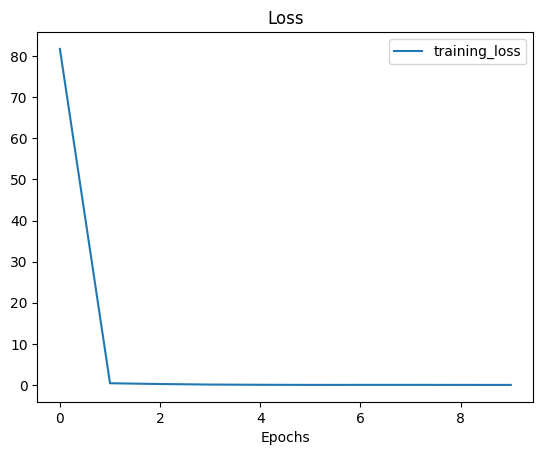

In [ ]:
plot_loss_curve(history)

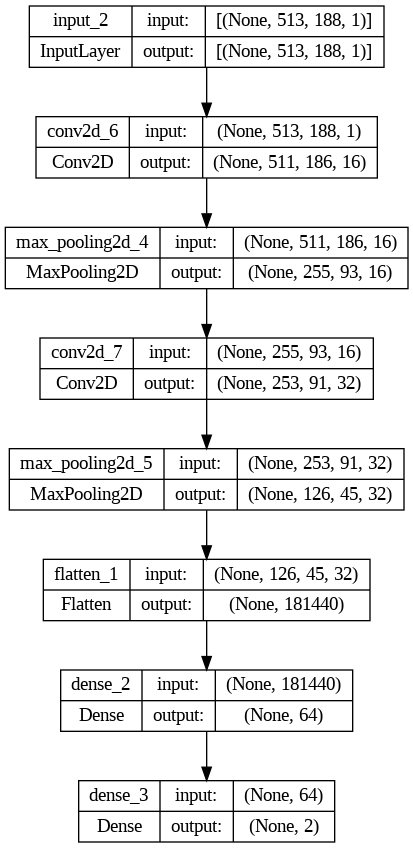

In [ ]:
from keras.utils import plot_model

plot_model(model, to_file='model_plot_1.png', show_shapes=True, show_layer_names=True)

## Model 2

In [ ]:
# TinyVGG Architecture
input = Input(shape=Input_shape)

x = Conv2D(32, 3, activation='relu')(input)
x = Conv2D(32, 3, activation='relu')(x)
x = MaxPooling2D(2)(x)
x = MaxPooling2D(2)(x)

x = Conv2D(32, 3, activation='relu')(x)
x = Conv2D(64, 3, activation='relu')(x)
x = MaxPooling2D(2)(x)

x = Conv2D(64, 3, activation='relu')(x)
x = Conv2D(64, 3, activation='relu')(x)
x = MaxPooling2D(2)(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)

Output = Dense(2, activation='softmax')(x)

model_2 = Model(input, Output)

model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 513, 188, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 511, 186, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 509, 184, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 254, 92, 32)       0         
 D)                                                              
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 127, 46, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 125, 44, 32)       9248  

In [ ]:
# Compile the model
model_2.compile(optimizer=keras.optimizers.AdamW(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_2 = model_2.fit(X,
                        Y,
                        epochs=35,
                        batch_size=Batch_size
                        )

Epoch 1/35
88/88 [==============================] - 62s 250ms/step - loss: 4.2314 - accuracy: 0.5057
Epoch 2/35
88/88 [==============================] - 5s 62ms/step - loss: 0.6724 - accuracy: 0.5921
Epoch 3/35
88/88 [==============================] - 5s 61ms/step - loss: 0.6625 - accuracy: 0.5800
Epoch 4/35
88/88 [==============================] - 5s 61ms/step - loss: 0.6744 - accuracy: 0.5854
Epoch 5/35
88/88 [==============================] - 5s 61ms/step - loss: 0.6931 - accuracy: 0.5396
Epoch 6/35
88/88 [==============================] - 5s 61ms/step - loss: 0.6806 - accuracy: 0.5707
Epoch 7/35
88/88 [==============================] - 6s 65ms/step - loss: 0.6581 - accuracy: 0.6129
Epoch 8/35
88/88 [==============================] - 5s 60ms/step - loss: 0.6411 - accuracy: 0.6289
Epoch 9/35
88/88 [==============================] - 5s 61ms/step - loss: 0.5022 - accuracy: 0.7821
Epoch 10/35
88/88 [==============================] - 5s 61ms/step - loss: 0.3941 - accuracy: 0.8343
Epoch 1

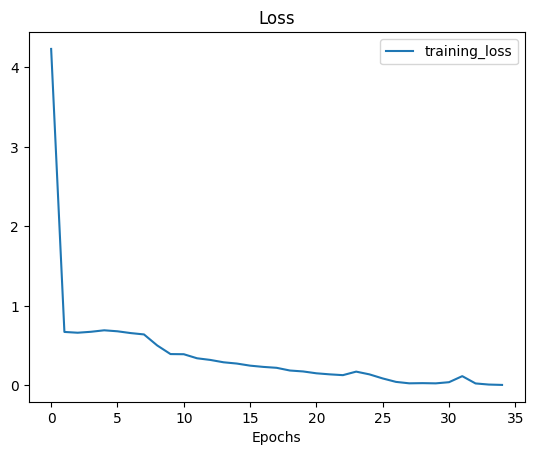

In [ ]:
plot_loss_curve(history_2)

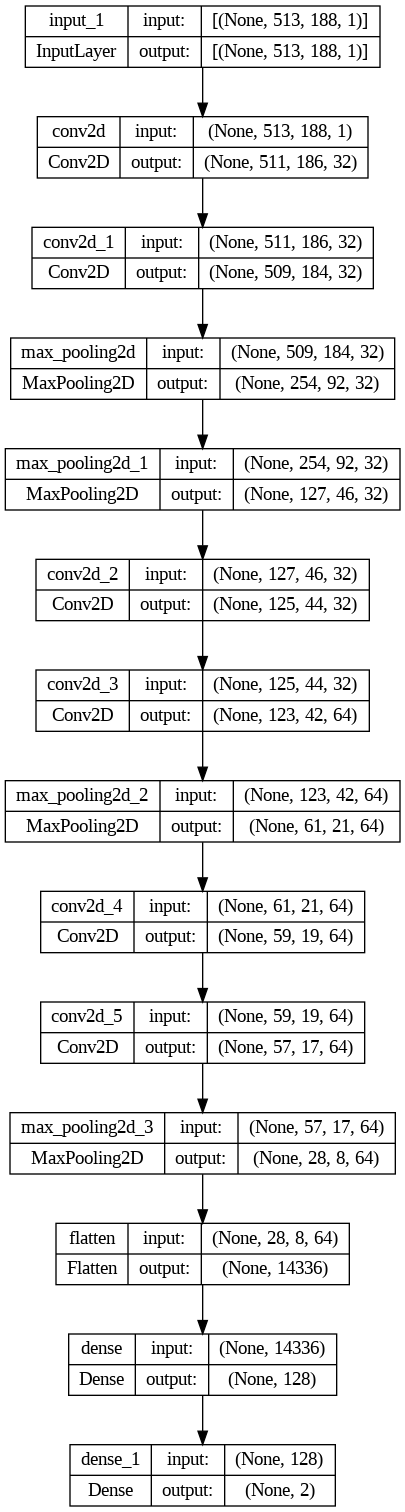

In [ ]:
plot_model(model_2, to_file='model_plot_2.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Saving the Model 2
model_2.save('/content/drive/MyDrive/Model.keras')

## Summary

**`Model 1:`** \\
**Params** : 11617154 Params \\
**Epochs** : 10 \\
**Training Accuracy** : 0.9986 (Overfitting)

**`Model 2:`** \\
**Params** : 1946562 Params \\
**Epochs** : 35 \\
**Training Accuracy** : 0.9986

Now, let's see how they perform with an unknown Data

# Predictions

## Helper functions

In [ ]:
def butter_lowpass(cutoff, nyq_freq, order=4):
    normal_cutoff = float(cutoff) / nyq_freq
    b, a = signal.butter(order, normal_cutoff, btype='lowpass')
    return b, a

def butter_lowpass_filter(data, cutoff_freq, nyq_freq, order=4):
    # Source: https://github.com/guillaume-chevalier/filtering-stft-and-laplace-transform
    b, a = butter_lowpass(cutoff_freq, nyq_freq, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def downsample_file( amplitudes, original_sr, new_sample_rate):
    return librosa.resample(y=amplitudes,
                            orig_sr=original_sr,
                            target_sr=new_sample_rate,
                            res_type='kaiser_fast'), new_sample_rate

In [ ]:
def predict_on_entire_file(audio, sample_rate, lowpass_cutoff,
                           downsample_rate, nyquist_rate, model, verbose=False):

    # Apply a low pass fitler to get rid of high frequency components
    filtered = butter_lowpass_filter(audio, lowpass_cutoff, nyquist_rate)

    # Downsample the audio
    amplitudes, sample_rate = downsample_file(filtered, sample_rate, downsample_rate)

    # Duration of file
    file_duration = len(amplitudes)/sample_rate

    # Number of segments
    segments = math.floor(file_duration) - 2

    # Store predictions in this list
    predictions = []

    # Loop over the file and work in small "segments"
    for position in range (0, segments):

        # Determine start of segment
        start_position = position

        # Determine end of segment
        end_position = start_position + 2
        if verbose:
          print('start position:', start_position)
          print('end position:', end_position)

        # Extract a 2 second segment from the audio file
        audio_segment = amplitudes[start_position*downsample_rate:end_position*downsample_rate]

        # Create the spectrogram
        S = audio_to_spectrogram(audio_segment)

        # Input spectrogram into model
        softmax = model.predict(np.reshape(S, (1,*S.shape)), verbose=0)
        if verbose:
          print ('model output:', softmax)

        # Binary output
        binary_prediction = np.argmax(softmax,-1)

        if verbose:
          print ('binary output:', binary_prediction[0])

        # Append result
        predictions.append('absence' if np.argmax(softmax,-1)[0]== 0 else 'presence')

    counts = collections.Counter(predictions)
    return predictions, counts

In [ ]:
# Creating a function to make it easy :-)
def predict_indices(file_path, lowpass_cutoff, downsample_rate, nyquist_rate, model, verbose=False):
    testfile, sr = librosa.load(file_path)
    predictions, counts = predict_on_entire_file(testfile, sr, lowpass_cutoff, downsample_rate, nyquist_rate, model, verbose)
    df_predictions = pd.DataFrame(predictions, columns=['BinaryPrediction'])
    prediction_indices = df_predictions[df_predictions['BinaryPrediction'] == 'presence'].index.values
    return prediction_indices, counts

# print the indices and the time range
def print_indices(file_path, lowpass_cutoff, downsample_rate, nyquist_rate, model, verbose=False, output=True):
    indices, counts = predict_indices(file_path, lowpass_cutoff, downsample_rate, nyquist_rate, model, verbose)
    if output:
      print('--------------------------')
      print('There is presence in:')
    for i in indices:
        start_time = i
        end_time = start_time + 2
        if output:
          print(f'Index {i}: {start_time} - {end_time} seconds')

    # Print how many '1' and '0'
    print('------------------------')
    print('There are', counts['absence'], 'segments predicted as 0 (absence)')
    print('There are', counts['presence'], 'segments predicted as 1 (presence)')
    # Return the indices and the counts
    return counts['presence'], counts['absence']

## Test Cases

### Test 1

In [ ]:
# Model 1
presence, absence = print_indices('./Audio/23_2-2-2024=20_51_34.wav', lowpass_cutoff, downsample_rate, nyquist_rate, model, verbose=True)

start position: 0
end position: 2
model output: [[0. 1.]]
binary output: 1
start position: 1
end position: 3
model output: [[2.104e-05 1.000e+00]]
binary output: 1
start position: 2
end position: 4
model output: [[3.874e-04 9.995e-01]]
binary output: 1
start position: 3
end position: 5
model output: [[2.909e-04 9.995e-01]]
binary output: 1
start position: 4
end position: 6
model output: [[6.67e-05 1.00e+00]]
binary output: 1
start position: 5
end position: 7
model output: [[8.41e-04 9.99e-01]]
binary output: 1
start position: 6
end position: 8
model output: [[0. 1.]]
binary output: 1
start position: 7
end position: 9
model output: [[0. 1.]]
binary output: 1
start position: 8
end position: 10
model output: [[4.983e-04 9.995e-01]]
binary output: 1
start position: 9
end position: 11
model output: [[2.26e-06 1.00e+00]]
binary output: 1
start position: 10
end position: 12
model output: [[6.e-07 1.e+00]]
binary output: 1
start position: 11
end position: 13
model output: [[1.e-07 1.e+00]]
bin

In [ ]:
# Model 2
presence, absence = print_indices('./Audio/23_2-2-2024=20_51_34.wav', lowpass_cutoff, downsample_rate, nyquist_rate, model_2, verbose=True)

start position: 0
end position: 2
model output: [[1.000e+00 5.156e-05]]
binary output: 0
start position: 1
end position: 3
model output: [[9.995e-01 5.760e-04]]
binary output: 0
start position: 2
end position: 4
model output: [[1. 0.]]
binary output: 0
start position: 3
end position: 5
model output: [[0.04218 0.958  ]]
binary output: 1
start position: 4
end position: 6
model output: [[0. 1.]]
binary output: 1
start position: 5
end position: 7
model output: [[0.998    0.002172]]
binary output: 0
start position: 6
end position: 8
model output: [[0. 1.]]
binary output: 1
start position: 7
end position: 9
model output: [[1.675e-05 1.000e+00]]
binary output: 1
start position: 8
end position: 10
model output: [[0. 1.]]
binary output: 1
start position: 9
end position: 11
model output: [[0. 1.]]
binary output: 1
start position: 10
end position: 12
model output: [[0. 1.]]
binary output: 1
start position: 11
end position: 13
model output: [[0.001289 0.9985  ]]
binary output: 1
start position: 12

### Test 2

In [ ]:
# Model 1
presence, absence = print_indices('./Audio/4_4_aud4-8.wav', lowpass_cutoff, downsample_rate, nyquist_rate, model, verbose=False)

--------------------------
There is presence in:
Index 0: 0 - 2 seconds
Index 1: 1 - 3 seconds
Index 2: 2 - 4 seconds
Index 3: 3 - 5 seconds
Index 4: 4 - 6 seconds
Index 5: 5 - 7 seconds
Index 6: 6 - 8 seconds
Index 7: 7 - 9 seconds
Index 8: 8 - 10 seconds
Index 9: 9 - 11 seconds
Index 10: 10 - 12 seconds
Index 11: 11 - 13 seconds
Index 12: 12 - 14 seconds
Index 13: 13 - 15 seconds
Index 14: 14 - 16 seconds
Index 15: 15 - 17 seconds
Index 16: 16 - 18 seconds
Index 17: 17 - 19 seconds
Index 18: 18 - 20 seconds
Index 19: 19 - 21 seconds
Index 20: 20 - 22 seconds
Index 21: 21 - 23 seconds
Index 22: 22 - 24 seconds
Index 23: 23 - 25 seconds
Index 24: 24 - 26 seconds
Index 25: 25 - 27 seconds
Index 26: 26 - 28 seconds
------------------------
There are 0 segments predicted as 0 (absence)
There are 27 segments predicted as 1 (presence)


In [ ]:
# Model 2
presence, absence = print_indices('./Audio/4_4_aud4-8.wav', lowpass_cutoff, downsample_rate, nyquist_rate, model_2, verbose=False)

--------------------------
There is presence in:
Index 1: 1 - 3 seconds
Index 2: 2 - 4 seconds
Index 3: 3 - 5 seconds
Index 4: 4 - 6 seconds
Index 5: 5 - 7 seconds
Index 6: 6 - 8 seconds
Index 7: 7 - 9 seconds
Index 8: 8 - 10 seconds
Index 9: 9 - 11 seconds
Index 10: 10 - 12 seconds
Index 11: 11 - 13 seconds
Index 12: 12 - 14 seconds
Index 13: 13 - 15 seconds
Index 14: 14 - 16 seconds
Index 15: 15 - 17 seconds
Index 16: 16 - 18 seconds
Index 17: 17 - 19 seconds
Index 18: 18 - 20 seconds
Index 20: 20 - 22 seconds
Index 21: 21 - 23 seconds
Index 22: 22 - 24 seconds
Index 23: 23 - 25 seconds
Index 24: 24 - 26 seconds
Index 25: 25 - 27 seconds
------------------------
There are 3 segments predicted as 0 (absence)
There are 24 segments predicted as 1 (presence)


### Test 3

In [ ]:
# Model 1
presence, absence = print_indices('./Audio/16_2-2-2024=20_59_12.wav', lowpass_cutoff, downsample_rate, nyquist_rate, model, verbose=False)

--------------------------
There is presence in:
Index 0: 0 - 2 seconds
Index 1: 1 - 3 seconds
Index 2: 2 - 4 seconds
Index 3: 3 - 5 seconds
Index 4: 4 - 6 seconds
Index 5: 5 - 7 seconds
Index 6: 6 - 8 seconds
Index 7: 7 - 9 seconds
Index 8: 8 - 10 seconds
Index 9: 9 - 11 seconds
Index 10: 10 - 12 seconds
Index 11: 11 - 13 seconds
Index 12: 12 - 14 seconds
Index 13: 13 - 15 seconds
Index 14: 14 - 16 seconds
Index 15: 15 - 17 seconds
Index 16: 16 - 18 seconds
Index 17: 17 - 19 seconds
Index 18: 18 - 20 seconds
Index 19: 19 - 21 seconds
Index 20: 20 - 22 seconds
Index 21: 21 - 23 seconds
Index 22: 22 - 24 seconds
Index 23: 23 - 25 seconds
Index 24: 24 - 26 seconds
Index 25: 25 - 27 seconds
Index 26: 26 - 28 seconds
------------------------
There are 0 segments predicted as 0 (absence)
There are 27 segments predicted as 1 (presence)


In [ ]:
# Model 2
presence, absence = print_indices('./Audio/16_2-2-2024=20_59_12.wav', lowpass_cutoff, downsample_rate, nyquist_rate, model_2, verbose=False)

--------------------------
There is presence in:
Index 0: 0 - 2 seconds
Index 1: 1 - 3 seconds
Index 2: 2 - 4 seconds
Index 3: 3 - 5 seconds
Index 7: 7 - 9 seconds
Index 8: 8 - 10 seconds
Index 9: 9 - 11 seconds
Index 10: 10 - 12 seconds
Index 11: 11 - 13 seconds
Index 12: 12 - 14 seconds
Index 13: 13 - 15 seconds
Index 14: 14 - 16 seconds
Index 15: 15 - 17 seconds
Index 16: 16 - 18 seconds
Index 17: 17 - 19 seconds
Index 18: 18 - 20 seconds
Index 19: 19 - 21 seconds
Index 20: 20 - 22 seconds
Index 21: 21 - 23 seconds
Index 22: 22 - 24 seconds
Index 23: 23 - 25 seconds
Index 24: 24 - 26 seconds
Index 25: 25 - 27 seconds
------------------------
There are 4 segments predicted as 0 (absence)
There are 23 segments predicted as 1 (presence)


### Test 4 ....... n

In [ ]:
import csv

audio_dir ='./Audio'

# Save the results into a csv file
with open("output.csv", "w", newline="") as csv_file:
    writer = csv.writer(csv_file)
    header = ["file name", "model 1 presence", "model 1 absence", "model 2 presence", "model 2 absence"]
    writer.writerow(header)

    with open("./DataFiles/TestingFiles.txt", "r") as f:
        for line in f:
            file_name = line.strip()
            file_name = file_name + ".wav"
            file_path = os.path.join(audio_dir, file_name)

            if os.path.isfile(file_path):
                print('------------------------')
                print('Audio: ', file_name)
                # model 1
                model_1_presence, model_1_absence = print_indices(file_path, lowpass_cutoff, downsample_rate, nyquist_rate, model, output=False)
                # model 2
                model_2_presence, model_2_absence = print_indices(file_path, lowpass_cutoff, downsample_rate, nyquist_rate, model_2, output=False)
                # Write a row to the CSV file
                row = [file_name, model_1_presence, model_1_absence, model_2_presence, model_2_absence]
                writer.writerow(row)
            else:
                continue

------------------------
Audio:  21_3-2-2024=7_19_54.wav
------------------------
There are 3 segments predicted as 0 (absence)
There are 24 segments predicted as 1 (presence)
------------------------
There are 11 segments predicted as 0 (absence)
There are 16 segments predicted as 1 (presence)
------------------------
Audio:  23_2-2-2024=20_39_19.wav
------------------------
There are 6 segments predicted as 0 (absence)
There are 21 segments predicted as 1 (presence)
------------------------
There are 2 segments predicted as 0 (absence)
There are 25 segments predicted as 1 (presence)
------------------------
Audio:  19_19_fermat_12.wav
------------------------
There are 3 segments predicted as 0 (absence)
There are 24 segments predicted as 1 (presence)
------------------------
There are 19 segments predicted as 0 (absence)
There are 8 segments predicted as 1 (presence)
------------------------
Audio:  23_2-2-2024=20_42_49.wav
------------------------
There are 0 segments predicted as 

We can see that the model 2 can predict both birds and noise. \\
But to see which one is the best model, we have a Background Audio that has few vocalization and a lot of noise.

### Background Audio
I uploaded some background Audio to test on

In [ ]:
# Model 1
# Background Audio it should be empty with maybe a small amount of vocalization (not a lot)
presence, absence = print_indices('./Bkg_Test/2-2-2024=19-48-46.wav', lowpass_cutoff, downsample_rate, nyquist_rate, model, verbose=False)

--------------------------
There is presence in:
Index 1: 1 - 3 seconds
Index 3: 3 - 5 seconds
Index 4: 4 - 6 seconds
Index 5: 5 - 7 seconds
Index 6: 6 - 8 seconds
Index 7: 7 - 9 seconds
Index 9: 9 - 11 seconds
Index 11: 11 - 13 seconds
Index 12: 12 - 14 seconds
Index 13: 13 - 15 seconds
Index 14: 14 - 16 seconds
Index 15: 15 - 17 seconds
Index 16: 16 - 18 seconds
Index 17: 17 - 19 seconds
Index 18: 18 - 20 seconds
Index 19: 19 - 21 seconds
Index 21: 21 - 23 seconds
Index 22: 22 - 24 seconds
Index 23: 23 - 25 seconds
Index 24: 24 - 26 seconds
Index 25: 25 - 27 seconds
Index 26: 26 - 28 seconds
------------------------
There are 5 segments predicted as 0 (absence)
There are 22 segments predicted as 1 (presence)


In [ ]:
# Model 2
# Background Audio it should be empty with maybe a small amount of vocalization (not a lot)
presence, absence = print_indices('./Bkg_Test/2-2-2024=19-48-46.wav', lowpass_cutoff, downsample_rate, nyquist_rate, model_2, verbose=False)

--------------------------
There is presence in:
Index 0: 0 - 2 seconds
Index 5: 5 - 7 seconds
Index 6: 6 - 8 seconds
Index 8: 8 - 10 seconds
Index 12: 12 - 14 seconds
Index 14: 14 - 16 seconds
Index 17: 17 - 19 seconds
Index 24: 24 - 26 seconds
------------------------
There are 19 segments predicted as 0 (absence)
There are 8 segments predicted as 1 (presence)


## Discussion
Predicting on Background Audio to see if it learnt only bird sounds or the noise too. \\
`Model_1` predictions :  \\
There are **5 segments** predicted as 0 (absence) \\
There are **22 segments** predicted as 1 (presence)

`Model_2` predictions : \\
There are **19 segments** predicted as 0 (absence) \\
There are **8 segments** predicted as 1 (presence)

---
Even though the `model_1` with `12m params` performed well in the training set with `99% accuracy` we can see that it's overfitting and it didn't learn much and after predicting on a background audio that contains '0' and few of '1' it predict them all of them as '1'. \\
On the otherhand `model_2` with only `2m params` and with `99% accuracy` but we can see that it learnt some features and after predicting on a the same background audio we saw that it





## More Test with Background audios to make sure

### Audio 1

In [ ]:
# Model 1
presence, absence = print_indices('./Bkg_Test/2-2-2024=19_45_16.wav', lowpass_cutoff, downsample_rate, nyquist_rate, model, verbose=False)

--------------------------
There is presence in:
Index 0: 0 - 2 seconds
Index 2: 2 - 4 seconds
Index 3: 3 - 5 seconds
Index 4: 4 - 6 seconds
Index 5: 5 - 7 seconds
Index 6: 6 - 8 seconds
Index 7: 7 - 9 seconds
Index 8: 8 - 10 seconds
Index 10: 10 - 12 seconds
Index 11: 11 - 13 seconds
Index 12: 12 - 14 seconds
Index 13: 13 - 15 seconds
Index 14: 14 - 16 seconds
Index 15: 15 - 17 seconds
Index 16: 16 - 18 seconds
Index 17: 17 - 19 seconds
Index 18: 18 - 20 seconds
Index 19: 19 - 21 seconds
Index 20: 20 - 22 seconds
Index 21: 21 - 23 seconds
Index 22: 22 - 24 seconds
Index 23: 23 - 25 seconds
Index 24: 24 - 26 seconds
Index 25: 25 - 27 seconds
Index 26: 26 - 28 seconds
------------------------
There are 2 segments predicted as 0 (absence)
There are 25 segments predicted as 1 (presence)


In [ ]:
# Model 2
presence, absence = print_indices('./Bkg_Test/2-2-2024=19_45_16.wav', lowpass_cutoff, downsample_rate, nyquist_rate, model_2, verbose=False)

--------------------------
There is presence in:
Index 21: 21 - 23 seconds
------------------------
There are 26 segments predicted as 0 (absence)
There are 1 segments predicted as 1 (presence)


### Audio 2

In [ ]:
# Model 1
presence, absence = print_indices('./Bkg_Test/2-2-2024=19_44_6.wav', lowpass_cutoff, downsample_rate, nyquist_rate, model, verbose=False)

--------------------------
There is presence in:
Index 0: 0 - 2 seconds
Index 1: 1 - 3 seconds
Index 2: 2 - 4 seconds
Index 3: 3 - 5 seconds
Index 4: 4 - 6 seconds
Index 5: 5 - 7 seconds
Index 6: 6 - 8 seconds
Index 7: 7 - 9 seconds
Index 8: 8 - 10 seconds
Index 10: 10 - 12 seconds
Index 11: 11 - 13 seconds
Index 12: 12 - 14 seconds
Index 14: 14 - 16 seconds
Index 15: 15 - 17 seconds
Index 16: 16 - 18 seconds
Index 17: 17 - 19 seconds
Index 18: 18 - 20 seconds
Index 19: 19 - 21 seconds
Index 20: 20 - 22 seconds
Index 21: 21 - 23 seconds
Index 22: 22 - 24 seconds
Index 23: 23 - 25 seconds
Index 24: 24 - 26 seconds
Index 25: 25 - 27 seconds
Index 26: 26 - 28 seconds
------------------------
There are 2 segments predicted as 0 (absence)
There are 25 segments predicted as 1 (presence)


In [ ]:
# Model 2
presence, absence = print_indices('./Bkg_Test/2-2-2024=19_44_6.wav', lowpass_cutoff, downsample_rate, nyquist_rate, model_2, verbose=False)

--------------------------
There is presence in:
Index 15: 15 - 17 seconds
Index 16: 16 - 18 seconds
Index 22: 22 - 24 seconds
------------------------
There are 24 segments predicted as 0 (absence)
There are 3 segments predicted as 1 (presence)


### Audio 3

In [ ]:
# Model 1
presence, absence = print_indices('./Bkg_Test/2-2-2024=19_45_51.wav', lowpass_cutoff, downsample_rate, nyquist_rate, model, verbose=False)

--------------------------
There is presence in:
Index 1: 1 - 3 seconds
Index 2: 2 - 4 seconds
Index 3: 3 - 5 seconds
Index 4: 4 - 6 seconds
Index 5: 5 - 7 seconds
Index 6: 6 - 8 seconds
Index 7: 7 - 9 seconds
Index 8: 8 - 10 seconds
Index 9: 9 - 11 seconds
Index 10: 10 - 12 seconds
Index 11: 11 - 13 seconds
Index 12: 12 - 14 seconds
Index 13: 13 - 15 seconds
Index 14: 14 - 16 seconds
Index 15: 15 - 17 seconds
Index 16: 16 - 18 seconds
Index 17: 17 - 19 seconds
Index 18: 18 - 20 seconds
Index 19: 19 - 21 seconds
Index 21: 21 - 23 seconds
Index 22: 22 - 24 seconds
Index 23: 23 - 25 seconds
Index 24: 24 - 26 seconds
Index 25: 25 - 27 seconds
Index 26: 26 - 28 seconds
------------------------
There are 2 segments predicted as 0 (absence)
There are 25 segments predicted as 1 (presence)


In [ ]:
# Model 2
presence, absence = print_indices('./Bkg_Test/2-2-2024=19_45_51.wav', lowpass_cutoff, downsample_rate, nyquist_rate, model_2, verbose=False)

--------------------------
There is presence in:
Index 9: 9 - 11 seconds
Index 17: 17 - 19 seconds
Index 23: 23 - 25 seconds
------------------------
There are 24 segments predicted as 0 (absence)
There are 3 segments predicted as 1 (presence)


## Results
We can see, as discussed above in the Discussion, that the `first model` is only predicting '1' for almost every noise and vocalization. But we can see that `Model 2` is performing well, distinguishing between noise '0' and vocalization'1'.